In [1]:
%matplotlib inline
import os
import cv2
import json
import torch
import torchvision
from torch import nn
import pandas as pd
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, ConcatDataset

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
##############################################################
# CLASS TO NORMALIZE OUR DATA
##############################################################

class Normalization(object):
    def __init__(self, mean, std):
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def __call__(self, sample):
        image, label1, label2, label3 = sample['image'],\
        sample['label_age'], sample['label_gender'], sample['label_race']
        
        return {'image': image,
                'label_age': label1,
                'label_gender': label2,
                'label_race': label3}

##############################################################
# CLASS FOR DATA HANDLING IN PYTORCH
##############################################################

class MyData(Dataset):
    def __init__(self, image_tensor, annotations_tensor, train=True, transform=None):
        
        #Leaving only image related columns
        features=image_tensor.float()
        y = annotations_tensor.float()
        device = torch.device('cuda')
            
        ##########################################################
        # splitting the data into train and validation set
        ##########################################################
        
        X_train, X_test, y_train, y_test= train_test_split(features, y, test_size=0.2)
        
        if train==True:
            self.x=X_train
            self.y=y_train
        else:
            self.x=X_test
            self.y=y_test
            
        #############################
        # TRANSFORMS
        #############################
        
        # normalize data, w.o. Bessel Correction -> n instead of n-1
        std, mean = torch.std_mean(self.x.float(), unbiased=False)

        if transform is None:
            intrinsic_transform = torch.nn.Sequential(transforms.Normalize(mean, std))
        
            #Applying transformation
            self.transform=intrinsic_transform
        else:
            #Applying transformation
            self.transform=transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image=self.x[idx]
        labels=self.y[idx]
        
        #Applying transformation
        #if self.transform:
            #image=self.transform(image)
        return (image,labels)

In [3]:
##############################################################
# LOAD TENSORS FROM FILES
##############################################################

device = torch.device('cuda')

annotations_tensor = torch.load('tensors/humans_monsters_annotation_tensor.pt', map_location=device)
plain_image_tensor = torch.load('tensors/humans_monsters_plain_image_tensor.pt', map_location=device)

#rgb_tensor = torch.load('tensors/humans_monsters_rgb_image_tensor.pt', map_location=device)
#texture_tensor = torch.load('tensors/humans_monsters_texture_image_tensor.pt', map_location=device)

##############################################################
# CREATE DATA OBJECTS AND PREPARE THEM FOR THE CNN WITH
# THE DATA LOADER CLASS
##############################################################

plain_dataset_train = MyData(plain_image_tensor, annotations_tensor, train=True)
plain_dataset_test = MyData(plain_image_tensor, annotations_tensor, train=False)

train_loader = DataLoader(plain_dataset_train, batch_size=100, num_workers=0, shuffle=True)
test_loader = DataLoader(plain_dataset_test, batch_size=100, num_workers=0, shuffle=True)
                       
print("Dataset/s loaded")

Dataset/s loaded


#### Original Architecture

* Input Layer: fixed image of size 200 x 200 x 1
* Second Layer: Convolution with 5-pixels square kernel. Output: feature map of size 196 x 196 x 8.

* RelU: The tensor is then passed through a ReLU and batch normalization is applied.

* Pooling Layer: Max pooling with stride 2 
* Convolution Layer: Convolution with 5-pixels square kernel and 16 output channels Output: Tensor of size 94 x 94 x 16.

* Pooling Layer: Max pooling with stride 2. And then flatten. Output: tensor of size 35344

* Fully Connected Layer:
* RelU: The tensor is then passed through a ReLU and batch normalization is applied.

* Regressor Layer: Output: 8 human body dimensions in meters

#### Training
* 20 epochs
* mini_batc_size = 100
* Loss = MSE
* learning_rate = 0.01
* momentum = 0.9
* TODO: regressor funktion
* For layers
* 
* https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

In [4]:
##############################################################
# CONVOLUTIONAL NEURAL NETWORK
##############################################################

class ConvNet(nn.Module):
    '''
    Simple Convolutional Neural Network
    '''
    def __init__(self):
        
        super().__init__()
        self.layers = nn.Sequential(

          # input layer 200 x 200 x 1 - (in: 1 color channel, out: 8 Channels, ...)
          # output 196 x 196 x 8  
          nn.Conv2d(1, 8, kernel_size=5),
          nn.ReLU(),

          # input 196 x 196 x 8 
          # output 98 x 98 x 8
          nn.MaxPool2d(stride=2, kernel_size=1),

          # input 98 x 98 x 8
          # output 94 x 94 x 16
          nn.Conv2d(8, 16, kernel_size=5),
          nn.ReLU(),

          # input 94 x 94 x 16
          # output 47 x 47 x 16
          nn.MaxPool2d(stride=2, kernel_size=1),

          # Pooling Layer: Max pooling with stride 2. And then flatten.
          # Output: tensor of size 35344 = 47 x 47 x 16
          nn.Flatten(),
          nn.Linear(35344, 35344),
          nn.ReLU(),

          # Last Layer - Regressor
          # input 35344
          # output 8
          nn.Linear(35344, 8)

        )

    def forward(self, x):
        inputs = x.unsqueeze(1)
        outputs = self.layers(inputs)
        return outputs

In [5]:
##############################################################
# TRAIN LOOP
##############################################################

def train_loop(dataloader, model, loss_fn, optimizer):
    print("Train:")
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

##############################################################
# TEST LOOP
##############################################################

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    
    num_batches = len(dataloader)
    test_loss, correct, diff, diff_fracture = 0, 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()
            diff += (abs(pred.argmax(0) - y)).type(torch.float).sum().item() #with or without argmax?
            diff_fracture += (abs(pred.argmax(0) - y)/y).type(torch.float).sum().item() #with or without argmax?

    test_loss /= num_batches
    correct /= size
    diff /= size
    diff_fracture /= size
    print(f"\nTest Error: \n AMAD: {(diff):>0.3f}%, \n ARPE: {(diff_fracture):>0.3f}%, \n Avg loss: {test_loss:>6f} \n")
    
    return test_loss

In [6]:
##############################################################
# HYPER PARAMETERS
##############################################################

# Loss Function
loss_fn = nn.MSELoss()

# Model of our Neural Network - push to GPU
model = ConvNet().to(device)
                     
# Use Stochastic Gradient Descent as function to optimize
learning_rate = 0.00001
momentum = 0.09
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##############################################################
# TRAIN NETWORK 
##############################################################

# Epochs
epochs = 100

# Store AVG Loss for plotting
avg_losses = []
                     
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    avg_losses.append(test_loop(test_loader, model, loss_fn))
    
print("Done!")
print(avg_losses)

Epoch 1
-------------------------------
Train:
loss: 34.606514  [    0/11200]
loss: 1.007222  [ 5000/11200]
loss: 0.932647  [10000/11200]

Test Error: 
 AMAD: 388.536%, 
 ARPE: inf%, 
 Avg loss: 0.949077 

Epoch 2
-------------------------------
Train:
loss: 0.969328  [    0/11200]
loss: 0.953406  [ 5000/11200]
loss: 0.962768  [10000/11200]

Test Error: 
 AMAD: 406.816%, 
 ARPE: inf%, 
 Avg loss: 0.937563 

Epoch 3
-------------------------------
Train:
loss: 0.968451  [    0/11200]
loss: 0.924813  [ 5000/11200]
loss: 0.915331  [10000/11200]

Test Error: 
 AMAD: 371.755%, 
 ARPE: inf%, 
 Avg loss: 0.933996 

Epoch 4
-------------------------------
Train:
loss: 0.957287  [    0/11200]
loss: 0.942650  [ 5000/11200]
loss: 0.950724  [10000/11200]

Test Error: 
 AMAD: 391.381%, 
 ARPE: inf%, 
 Avg loss: 0.932064 

Epoch 5
-------------------------------
Train:
loss: 0.888616  [    0/11200]
loss: 0.936362  [ 5000/11200]
loss: 0.933522  [10000/11200]

Test Error: 
 AMAD: 381.110%, 
 ARPE: inf

loss: 0.899631  [ 5000/11200]
loss: 0.917783  [10000/11200]

Test Error: 
 AMAD: 393.522%, 
 ARPE: inf%, 
 Avg loss: 0.887601 

Epoch 42
-------------------------------
Train:
loss: 0.886822  [    0/11200]
loss: 0.911414  [ 5000/11200]
loss: 0.891826  [10000/11200]

Test Error: 
 AMAD: 381.141%, 
 ARPE: inf%, 
 Avg loss: 0.885512 

Epoch 43
-------------------------------
Train:
loss: 0.886176  [    0/11200]
loss: 0.878383  [ 5000/11200]
loss: 0.884055  [10000/11200]

Test Error: 
 AMAD: 352.968%, 
 ARPE: inf%, 
 Avg loss: 0.883314 

Epoch 44
-------------------------------
Train:
loss: 0.878875  [    0/11200]
loss: 0.899726  [ 5000/11200]
loss: 0.914068  [10000/11200]

Test Error: 
 AMAD: 389.253%, 
 ARPE: inf%, 
 Avg loss: 0.880996 

Epoch 45
-------------------------------
Train:
loss: 0.871180  [    0/11200]
loss: 0.892625  [ 5000/11200]
loss: 0.906653  [10000/11200]

Test Error: 
 AMAD: 399.789%, 
 ARPE: inf%, 
 Avg loss: 0.878547 

Epoch 46
-------------------------------
Train:


loss: 0.518187  [ 5000/11200]
loss: 0.526580  [10000/11200]

Test Error: 
 AMAD: 406.911%, 
 ARPE: inf%, 
 Avg loss: 0.519138 

Epoch 82
-------------------------------
Train:
loss: 0.523391  [    0/11200]
loss: 0.523169  [ 5000/11200]
loss: 0.505424  [10000/11200]

Test Error: 
 AMAD: 362.611%, 
 ARPE: inf%, 
 Avg loss: 0.495366 

Epoch 83
-------------------------------
Train:
loss: 0.494159  [    0/11200]
loss: 0.472498  [ 5000/11200]
loss: 0.495797  [10000/11200]

Test Error: 
 AMAD: 409.050%, 
 ARPE: inf%, 
 Avg loss: 0.470961 

Epoch 84
-------------------------------
Train:
loss: 0.476951  [    0/11200]
loss: 0.433294  [ 5000/11200]
loss: 0.476012  [10000/11200]

Test Error: 
 AMAD: 410.534%, 
 ARPE: inf%, 
 Avg loss: 0.446068 

Epoch 85
-------------------------------
Train:
loss: 0.430219  [    0/11200]
loss: 0.444414  [ 5000/11200]
loss: 0.426439  [10000/11200]

Test Error: 
 AMAD: 382.832%, 
 ARPE: inf%, 
 Avg loss: 0.420875 

Epoch 86
-------------------------------
Train:


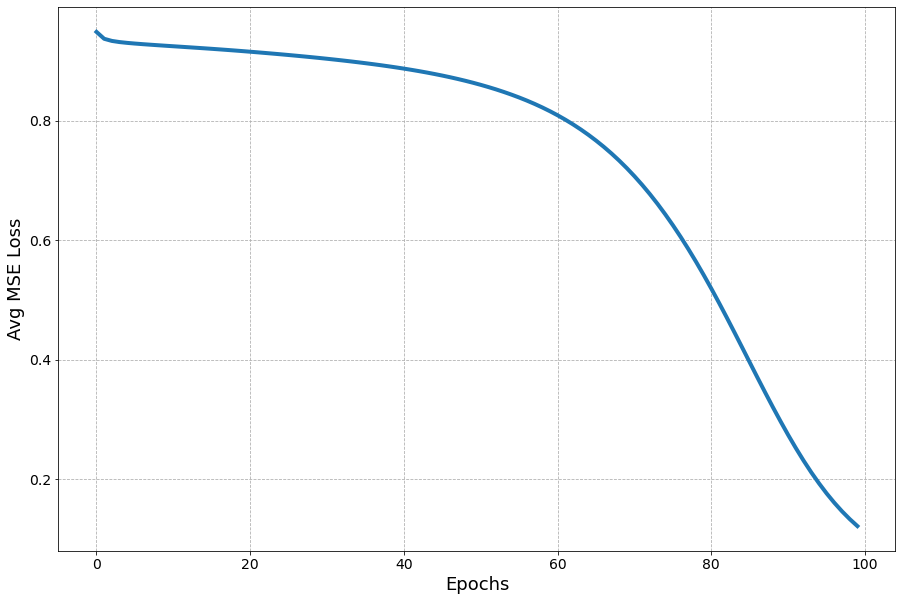

In [34]:
##############################################################
# PLOTS
##############################################################

#################################
# LOSS FUNCTION
#################################

plt.figure(figsize=(15, 10))
plt.plot(avg_losses, linewidth=4)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Avg MSE Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.grid(which='both', linestyle='--')
plt.show()